In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.tsa.api as smt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
sns.set(rc={'figure.figsize':(11, 4)})

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

torch.manual_seed(0)

np.random.seed(0)

,Energy_Generated,Efficiency,Energy_Exported,Energy_Used,Peak_Power,Peak_Time,Condition,Min_Temperature,Max_Temperature,Peak_Energy_Import,Off-Peak_Energy_Import,Shoulder_Energy_Import,High-Shoulder_Energy_Import,Insolation
Date,,,,,,,,,,,,,,
2020-02-03,3321,3.075,2910,0,646.0,13:40,Fine,6.0,29.0,NaN,NaN,NaN,NaN,4048
2020-02-04,1611,1.492,1275,0,678.0,14:30,Mostly Cloudy,8.0,16.0,NaN,NaN,NaN,NaN,4084
2020-02-05,4140,3.833,2816,0,737.0,12:40,Fine,0.0,16.0,NaN,NaN,NaN,NaN,4121
2020-02-06,4241,3.927,3585,0,740.0,13:00,Fine,-2.0,20.0,NaN,NaN,NaN,NaN,4157
2020-02-07,2654,2.457,2337,0,740.0,13:00,Fine,0.0,21.0,NaN,NaN,NaN,NaN,4194


2541


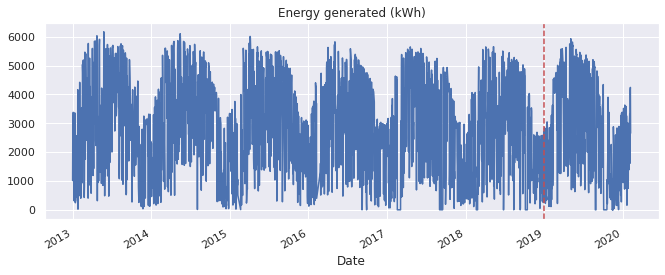

In [2]:
data = pd.read_csv("../DATA_COLLECTOR/AGGREGATION_PRODUCTION/aggreg_PRODUCTION_data.csv")
data.Date = pd.to_datetime(data['Date'],format='%Y%m%d')
data = data.sort_values(by='Date')
data = data[data.Date > '2012-12-31']
data = data.set_index('Date')

display(data.tail())
print(len(data))


data.Energy_Generated = pd.to_numeric(data.Energy_Generated)
data.Energy_Generated.plot(title="Energy generated (kWh)")
thresh_date = '2018-12-31' #'2019-02-07', '2019-08-31'
plt.axvline(x=thresh_date, c='r', linestyle='--')

In [3]:
features = ['Condition','Energy_Generated']
daily_data_with_weather = data[features]
dates = data.index.values

if('Condition' in features):
    conditions = set(daily_data_with_weather['Condition'])

encoder = LabelEncoder()
daily_data_with_weather.Condition = encoder.fit_transform(daily_data_with_weather.Condition)
conditions_labels = set(daily_data_with_weather['Condition'])

le_name_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print(le_name_mapping)

daily_data_with_weather = daily_data_with_weather[daily_data_with_weather.Condition != 3]

train_size = int(len(daily_data_with_weather) * 0.8)
test_size = len(daily_data_with_weather) - train_size
print(train_size,test_size)

# ensure all data is float
daily_data_with_weather = daily_data_with_weather.astype('float32')
daily_data_with_weather = daily_data_with_weather.dropna()
cols = daily_data_with_weather.columns.tolist()


{'Cloudy': 0, 'Fine': 1, 'Mostly Cloudy': 2, 'Not Sure': 3, 'Partly Cloudy': 4, 'Showers': 5}
1976 494


In [4]:
class MV_LSTM(torch.nn.Module):
    def __init__(self,n_features,seq_length,n_output=1,bias_init_values=[]):
        super(MV_LSTM, self).__init__()
        self.n_features = n_features
        self.seq_len = seq_length
        self.n_hidden = 20 # number of hidden states
        self.n_layers = 1 # number of LSTM layers (stacked)
        self.n_output = n_output

        self.l_lstm = torch.nn.LSTM(input_size = n_features, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True)

        self.l_linear = torch.nn.Linear(self.n_hidden*self.seq_len, self.n_output)
    
        if bias_init_values :
            for i in range(self.n_output):
                self.l_linear.bias.data[i] = bias_init_values[i]
               

    def init_hidden(self, batch_size):
        # even with batch_first = True this remains same as docs
        hidden_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
        cell_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
        self.hidden = (hidden_state, cell_state)


    def forward(self, x):        
        batch_size, seq_len, _ = x.size()

        lstm_out, self.hidden = self.l_lstm(x,self.hidden)
        x = lstm_out.contiguous().view(batch_size,-1)
        return self.l_linear(x)

In [5]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [6]:
def run_lstm(train_episodes, batch_size, mv_net, optimizer, trainX, trainY, testX, testY):
    loss_values = []
    val_loss_values = []
    for t in range(train_episodes):
        mv_net.train()
        for b in range(0,len(trainX),batch_size):
            inpt = trainX[b:b+batch_size,:,:]
            target = trainY[b:b+batch_size]    

            x_batch = torch.tensor(inpt,dtype=torch.float32)    
            y_batch = torch.tensor(target,dtype=torch.float32)

            mv_net.init_hidden(x_batch.size(0))
            output = mv_net(x_batch) 
            loss = criterion(output.view(-1), y_batch)  

            loss.backward()
            optimizer.step()        
            optimizer.zero_grad() 
            
        
        loss_values.append(loss)
            
        ##add test
        mv_net.eval()
        mv_net.init_hidden(testX.size(0))
        test_predict = mv_net(testX)
        loss = criterion(test_predict.view(-1), testY)  
        val_loss_values.append(loss)
        if t % 10 == 0:
            print("%d, loss %f val_loss %f" % (t,loss_values[-1],loss)) 

    return loss_values, val_loss_values

In [7]:
def split(data, train_size):
    X, y = split_sequences(data, n_timesteps)

    X_train = X[:train_size]
    y_train = y[:train_size]
    X_test = X[train_size:]
    y_test = y[train_size:] 

    trainX = Variable(torch.Tensor(X_train))
    trainY = Variable(torch.Tensor(y_train))

    testX = Variable(torch.Tensor(X_test))
    testY = Variable(torch.Tensor(y_test))

    return trainX, trainY, testX, testY


In [8]:
train_episodes = 50
batch_size = 128
n_features = len(features) # this is number of parallel inputs
n_timesteps = 48 # this is number of timesteps

In [9]:
cv_data = daily_data_with_weather.iloc[:train_size]
cv_dates = dates[:train_size]
print(len(cv_data))

1976



 365 365 730
2014-01-10T00:00:00.000000000 2015-01-16T00:00:00.000000000
0, loss 78.415207 val_loss 17.876141
10, loss 0.328448 val_loss 0.402087
20, loss 0.055409 val_loss 0.087437
30, loss 0.059544 val_loss 0.064612
40, loss 0.055869 val_loss 0.062706
RMSE = 1561


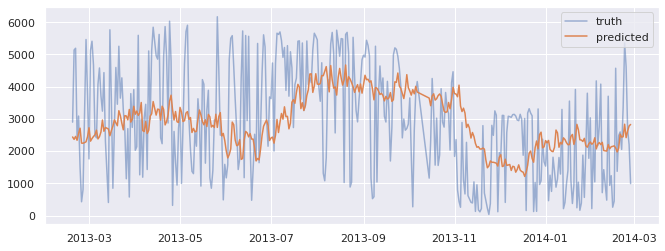


 730 365 1095
2015-01-16T00:00:00.000000000 2016-01-29T00:00:00.000000000
0, loss 17.222784 val_loss 23.552280
10, loss 0.105822 val_loss 0.066869
20, loss 0.069915 val_loss 0.058559
30, loss 0.068044 val_loss 0.057225
40, loss 0.065878 val_loss 0.055805
RMSE = 1473


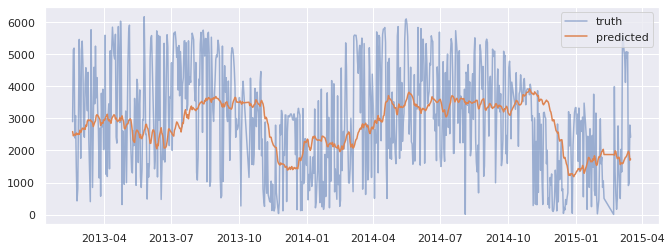


 1095 365 1460
2016-01-29T00:00:00.000000000 2017-02-16T00:00:00.000000000
0, loss 4.646717 val_loss 0.108430
10, loss 0.060907 val_loss 0.063455
20, loss 0.051156 val_loss 0.058714
30, loss 0.049549 val_loss 0.056626
40, loss 0.048096 val_loss 0.054577
RMSE = 1502


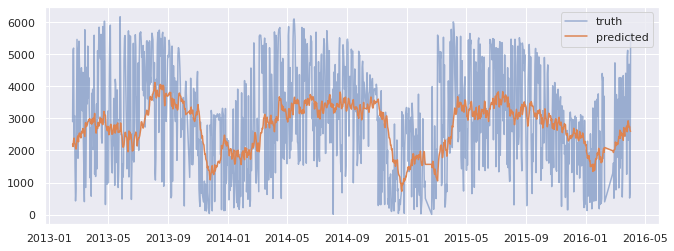


 1460 365 1825
2017-02-16T00:00:00.000000000 2018-02-18T00:00:00.000000000
0, loss 11.037606 val_loss 10.858801
10, loss 0.067475 val_loss 0.060806
20, loss 0.061270 val_loss 0.048648
30, loss 0.042905 val_loss 0.037780
40, loss 0.027003 val_loss 0.026794
RMSE = 1756


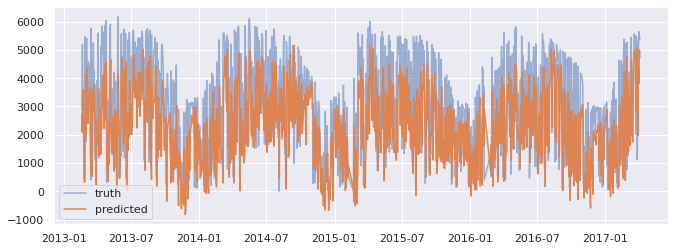

In [19]:
rmse_list = []
cv_test_size = 365
resid_list = []

for cv_train_size in range(cv_test_size,train_size-cv_test_size,cv_test_size):
    print("\n", cv_train_size, cv_test_size, cv_train_size+cv_test_size)
    print(dates[cv_train_size], dates[cv_train_size+cv_test_size])

    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(cv_data.iloc[:cv_train_size])
    scaled = scaler.transform(cv_data.iloc[:cv_train_size+cv_test_size])
    target_scaler = MinMaxScaler(feature_range=(0, 1))
    target_scaler.fit(cv_data.iloc[:cv_train_size].Energy_Generated.values.reshape(-1,1))

    # select data
    trainX, trainY, testX, testY = split(scaled, cv_train_size)

    # create NN
    mv_net = MV_LSTM(n_features,n_timesteps)
    criterion = torch.nn.MSELoss() # reduction='sum' created huge loss value
    optimizer = torch.optim.Adam(mv_net.parameters(), lr=1e-1,weight_decay=0.001)

    # train
    loss_values, val_loss_values = run_lstm(train_episodes, batch_size, mv_net, optimizer, trainX, trainY, testX, testY)

    # eval
    mv_net.eval()
    mv_net.init_hidden(testX.size(0))
    test_predict = mv_net(testX).detach().numpy()
    test_predict = target_scaler.inverse_transform(test_predict.reshape(-1, 1))

    lstm_rmse = mean_squared_error(test_predict[:,0],cv_data['Energy_Generated'].iloc[cv_train_size + n_timesteps:cv_train_size + cv_test_size:1] ,squared=False)
    print("RMSE = %d" % lstm_rmse) 

    rmse_list.append(lstm_rmse)

    
    # plot resid of training
    mv_net.init_hidden(trainX.size(0))
    train_predict = mv_net(trainX)
    train_predict = train_predict.data.numpy()
    train_truth = cv_data['Energy_Generated'].iloc[n_timesteps:cv_train_size + n_timesteps:1]
    resid_list.append(train_predict[:,0] - train_truth.values)

    # plot graph of predictions
    train_predict = target_scaler.inverse_transform(train_predict.reshape(-1, 1))
    x_train = cv_dates[n_timesteps:cv_train_size + n_timesteps:1]
    plt.plot(x_train, train_truth.values[:], alpha=0.5, label="truth")
    plt.plot(x_train, train_predict[:,0], label="predicted")
    plt.legend()
    plt.show()

In [29]:
def show_resid(resid, i):
    sns.kdeplot(resid, label="{} years of training".format(i+1))
    k2, p  = stats.normaltest(resid)
    print("mean =", np.mean(resid), "/ std  =", np.std(resid), "/ p =",  p)

mean = -2938.284 / std  = 1681.3768 / p = 1.0909818062806717e-28
mean = -2983.1057 / std  = 1669.68 / p = 5.018169424632174e-56
mean = -2983.062 / std  = 1631.9231 / p = 9.586451553240985e-75
mean = -2977.6562 / std  = 1629.956 / p = 9.492204914374702e-125


<function matplotlib.pyplot.show(*args, **kw)>

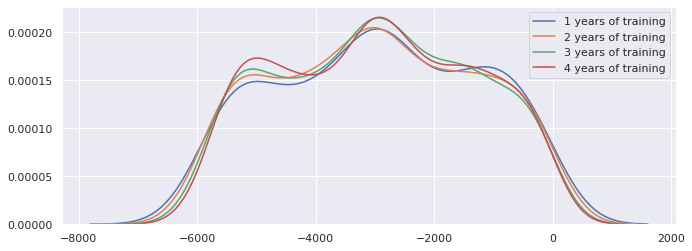

In [30]:
for i, resid in enumerate(resid_list):
    show_resid(resid, i)
plt.legend()
plt.show

In [31]:
print(np.mean(rmse_list), np.std(rmse_list))

1573.4012
